# Импортирование библиотек

In [ ]:
import json

import numpy as np
import pandas as pd

import re

import copy 

import nltk
#nltk.download('punkt')

from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Загрузка данных

In [3]:
json_train_file = '/content/drive/MyDrive/Cup IT 2023/ranking_train.jsonl'

with open(json_train_file) as json_file:
    json_list = list(json_file)

train = []
for json_str in json_list:
    data = json.loads(json_str)
    train.append(data)

In [4]:
len(train)

88107

In [5]:
train[88106]

{'text': 'Pay your rent with a Credit or Debit card. No landlord signup required',
 'comments': [{'text': 'Most major banks offer a service called &#x27;bill pay&#x27; which does this for free, directly from your checking account. Your bank first tries to pay the receiver electronically if they are in the banks network (most utility or other major companies would likely be in-network), and if they aren&#x27;t in network or if they are just a person and not a company, then the service sends them a physical check in the mail.[1]https:&#x2F;&#x2F;www.bankofamerica.com&#x2F;onlinebanking&#x2F;online-bill-pay....[2]https:&#x2F;&#x2F;www.chase.com&#x2F;online-banking&#x2F;online-bill-pay[3]https:&#x2F;&#x2F;www.wellsfargo.com&#x2F;online-banking&#x2F;bill-pay&#x2F;',
   'score': 0},
  {'text': 'It costs 3.25%, or $74.25 for the example of $2300. So if you&#x27;re looking to just rack up &quot;reward points&quot;, you&#x27;d be best pumping through a payment processor that takes a smaller cut

# Предобработка данных

## Длина комментария

In [6]:
train_df = []
num_posts = 0

for post in train:
    num_comments = 0
    num_posts += 1
    for comment in post['comments']:
        result = []
        result.append(num_posts)
        num_comments += 1
        result.append(num_comments)
        result.append(comment['score'])
        result.append(len(comment['text']))
        result.append(len(comment['text'].split(' ')))
        train_df.append(result)

In [7]:
train_df = pd.DataFrame(train_df, columns = ['post_num', 'comment_num', 'comment_score', 'symbols', 'words'])
train_df[25015:25023]

,post_num,comment_num,comment_score,symbols,words
25015,5004,1,0,4840,787
25016,5004,2,1,1561,267
25017,5004,3,2,845,147
25018,5004,4,3,732,118
25019,5004,5,4,516,95
25020,5005,1,0,814,151
25021,5005,2,1,1486,248
25022,5005,3,2,124,23


## Изменение регистра

In [10]:
def case_changes(dataset):
    for post in dataset:
        post['text'] = post['text'].lower()
        comments = post['comments']
        for comment in comments:
            comment['text'] = comment['text'].lower()
    return dataset

In [11]:
train = case_changes(train)
train[88106]

{'text': 'pay your rent with a credit or debit card. no landlord signup required',
 'comments': [{'text': 'most major banks offer a service called &#x27;bill pay&#x27; which does this for free, directly from your checking account. your bank first tries to pay the receiver electronically if they are in the banks network (most utility or other major companies would likely be in-network), and if they aren&#x27;t in network or if they are just a person and not a company, then the service sends them a physical check in the mail.[1]https:&#x2f;&#x2f;www.bankofamerica.com&#x2f;onlinebanking&#x2f;online-bill-pay....[2]https:&#x2f;&#x2f;www.chase.com&#x2f;online-banking&#x2f;online-bill-pay[3]https:&#x2f;&#x2f;www.wellsfargo.com&#x2f;online-banking&#x2f;bill-pay&#x2f;',
   'score': 0},
  {'text': 'it costs 3.25%, or $74.25 for the example of $2300. so if you&#x27;re looking to just rack up &quot;reward points&quot;, you&#x27;d be best pumping through a payment processor that takes a smaller cut

## Очистка

### Кодировка

In [12]:
def html_symbols(dataset):
    
    trans_table = {'&#x9;': '\\', '&#xA;': '\n', '&#x21;': '!', '&#x22;': '\"', '&#x23;': '#', '&#x24;': '$', 
                   '&#x25;': '%', '&#x26;': '&', '&#x27;': "'", '&#x28;': '(', '&#x29;': ')', '&#x2a;': '*', 
                   '&#x2b;': '+', '&#x2c;': ',', '&#x2e;': '.', '&#x2f;': '/', '&#x3a;': ':', '&#x3b;': ';', 
                   '&#x3c;': '<', '&#x3d;': '=', '&#x3e;': '>', '&#x3f;': '\?', '&#x40;': '@', '&#x5b;': '[', 
                   '&#x5c;': '\\', '&#x5d;': ']', '&#x5e;': '^', '&#x5f;': '_', '&#x60;': '`', '&#x7b;': '{', 
                   '&#x7c;': '|', '&#x7d;': '}', '&#9;': '\\', '&#10;': '\n', '&#33;': '!', '&#34;': '\"',
                   '&#35;': '#', '&#36;': '$', '&#37;': '%', '&#38;': '&', '&#39;': "'", '&#40;': '(', '&#41;': ')', 
                   '&#42;': '*', '&#43;': '+', '&#44;': ',', '&#46;': '.', '&#47;': '/', '&#58;': ':', '&#59;': ';', 
                   '&#60;': '<', '&#61;': '=', '&#62;': '>', '&#63;': '\?', '&#64;': '@', '&#91;': '[', '&#92;': '\\', 
                   '&#93;': ']', '&#94': '^', '&#95;': '_', '&#96;': '`', '&#123;': '{', '&#124;': '|', '&#125;': '}'}
    
    reg_ex_symb = r'(&#x\d+;)|(&#\d+;)'

    keys = list(trans_table.keys())
    values = list(trans_table.values())

    for post in dataset:
        for i in range(len(trans_table)):
            if keys[i] in post['text']:
                post['text'] = post['text'].replace(keys[i], values[i])
        post['text'] = re.sub(reg_ex_symb, ' ', post['text'])
        comments = post['comments']
        for comment in comments:
            for i in range(len(trans_table)):
                if keys[i] in comment['text']:
                    comment['text'] = comment['text'].replace(keys[i], values[i])
            comment['text'] = re.sub(reg_ex_symb, ' ', comment['text'])
    
    return dataset

In [13]:
train = html_symbols(train)
train[88106]

{'text': 'pay your rent with a credit or debit card. no landlord signup required',
 'comments': [{'text': "most major banks offer a service called 'bill pay' which does this for free, directly from your checking account. your bank first tries to pay the receiver electronically if they are in the banks network (most utility or other major companies would likely be in-network), and if they aren't in network or if they are just a person and not a company, then the service sends them a physical check in the mail.[1]https://www.bankofamerica.com/onlinebanking/online-bill-pay....[2]https://www.chase.com/online-banking/online-bill-pay[3]https://www.wellsfargo.com/online-banking/bill-pay/",
   'score': 0},
  {'text': "it costs 3.25%, or $74.25 for the example of $2300. so if you're looking to just rack up &quot;reward points&quot;, you'd be best pumping through a payment processor that takes a smaller cut.$5/month for debit is more reasonable, but my bank will mail my rent check for free.",
  

### Ссылки

Проведем неполную замену нежелательных символов и чисел, так как некоторые комментарии могут содержать несколько ссылок 

In [14]:
def urls(dataset):
    #reg_ex = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    reg_ex_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)://*[\S+]'   
    for post in dataset:
        post['text'] = re.sub(r'(\[\d\])', ' ', post['text'])
        post['text'] = re.sub(reg_ex_url, 'URL', post['text'])
        comments = post['comments']
        for comment in comments:
            comment['text'] = re.sub(r'(\[\d\])', ' ', comment['text'])
            comment['text'] = re.sub(reg_ex_url, 'URL', comment['text'])
    return dataset

In [15]:
train = urls(train)
train[88106]

{'text': 'pay your rent with a credit or debit card. no landlord signup required',
 'comments': [{'text': "most major banks offer a service called 'bill pay' which does this for free, directly from your checking account. your bank first tries to pay the receiver electronically if they are in the banks network (most utility or other major companies would likely be in-network), and if they aren't in network or if they are just a person and not a company, then the service sends them a physical check in the mail. URL URL URL",
   'score': 0},
  {'text': "it costs 3.25%, or $74.25 for the example of $2300. so if you're looking to just rack up &quot;reward points&quot;, you'd be best pumping through a payment processor that takes a smaller cut.$5/month for debit is more reasonable, but my bank will mail my rent check for free.",
   'score': 1},
  {'text': 'as many other comments have pointed out almost everyone with a debit card already has a free bill pay option from their bank.  thus the o

In [16]:
train_urls = []
train_count_urls = []
for post in train:
    for comment in post['comments']:
        if 'URL' in comment['text']:
            train_urls.append(1)
            train_count_urls.append(comment['text'].count('URL'))
        else:
            train_urls.append(0)
            train_count_urls.append(0)

In [17]:
train_df['url'] = train_urls
train_df['count_url'] = train_count_urls
train_df[25015:25023]

,post_num,comment_num,comment_score,symbols,words,url,count_url
25015,5004,1,0,4840,787,1,2
25016,5004,2,1,1561,267,0,0
25017,5004,3,2,845,147,0,0
25018,5004,4,3,732,118,0,0
25019,5004,5,4,516,95,0,0
25020,5005,1,0,814,151,0,0
25021,5005,2,1,1486,248,1,1
25022,5005,3,2,124,23,0,0


Теперь можно удалить все ссылки

In [18]:
def del_urls(dataset):
    for post in dataset:
        post['text'] = post['text'].replace('URL', '')
        comments = post['comments']
        for comment in comments:
            comment['text'] = comment['text'].replace('URL', '')
    return dataset

In [19]:
train = del_urls(train)
train[88106]

{'text': 'pay your rent with a credit or debit card. no landlord signup required',
 'comments': [{'text': "most major banks offer a service called 'bill pay' which does this for free, directly from your checking account. your bank first tries to pay the receiver electronically if they are in the banks network (most utility or other major companies would likely be in-network), and if they aren't in network or if they are just a person and not a company, then the service sends them a physical check in the mail.   ",
   'score': 0},
  {'text': "it costs 3.25%, or $74.25 for the example of $2300. so if you're looking to just rack up &quot;reward points&quot;, you'd be best pumping through a payment processor that takes a smaller cut.$5/month for debit is more reasonable, but my bank will mail my rent check for free.",
   'score': 1},
  {'text': 'as many other comments have pointed out almost everyone with a debit card already has a free bill pay option from their bank.  thus the only real 

### Email

In [20]:
def emails(dataset):
    reg_ex_mail = r'([a-z0-9_.+-]+)@[a-z0-9_.+-]+\.[a-z0-9_.+-]'
        
    for post in dataset:
        post['text'] = re.sub(reg_ex_mail, 'EMAIL', post['text'])
        comments = post['comments']
        for comment in comments:
            comment['text'] = re.sub(reg_ex_mail, 'EMAIL', comment['text'])
    return dataset

In [21]:
train = emails(train)

In [22]:
train_emails = []

for post in train:
    for comment in post['comments']:
        if 'EMAIL' in comment['text']:
            train_emails.append(1)
        else:
            train_emails.append(0)

In [23]:
train_df['email'] = train_emails
sum(train_df['email'])

1507

In [24]:
def del_emails(dataset):
    for post in dataset:
        post['text'] = post['text'].replace('EMAIL', '')
        comments = post['comments']
        for comment in comments:
            comment['text'] = comment['text'].replace('EMAIL', '')
    return dataset

In [25]:
train = del_emails(train)

### Сокращения
Прежде чем удалить все нежелательные символы (например, апострофы или точки), необходимо заменит все сокращения на их полные формы.

In [26]:
def cuts(dataset):
    trans_table = {"'m": ' am', "he's": 'he is', "she's": 'she is', "it's": 'it is', "'re": ' are', "i's": 'i was', "'ll": ' will', "this's": 'this is', "there's": 'there is', 
                   "can't": 'cannot', "won't": 'will not', "ain't": 'am not', "n't": ' not', "let's": 'let us', "'d": ' would', "'ve": ' have', "wontcha": 'will not you', 
                   "ntcha": ' not you', "whatcha": 'what are you', "gotcha": 'got you', "'em": ' them', 'asap': 'as soon as possible', 'pls': 'please', 'plz': 'please', 
                   'thx': 'thanks', 'lol': 'laughing out loud', 'rofl': 'rolling on the floor', 'omg': 'oh my god', 'idk': 'i do not know', 'imho': 'in my humble opinion',
                   'jk': 'just kidding', "jic": 'just in case', 'wdym': 'what do you mean', 'wanna': 'want to', 'gotta': 'got to', 'gonna': 'going to', 'gimme': 'give me', 
                   'lemme': 'let me', 'oughta': 'ought to', 'a lotta': 'a lot of', 'lotsa': 'lots of', 'kinda': 'kind of', 'sorta': 'sort of', 'cuppa': 'cup of', 'outta': 'out of',
                   "c'mon": 'come on', 'dunno': 'do not know', 'cuz': 'because', "'cos": 'because', "'coz": 'because', "'cause": 'because', 'shoulda': 'should have'}
    
    keys = list(trans_table.keys())
    values = list(trans_table.values())

    for post in dataset:
        for i in range(len(trans_table)):
            if keys[i] in post['text']:
                post['text'] = post['text'].replace(keys[i], values[i])
        comments = post['comments']
        for comment in comments:
            for i in range(len(trans_table)):
                if keys[i] in comment['text']:
                    comment['text'] = comment['text'].replace(keys[i], values[i])        
   
    return dataset

In [27]:
train = cuts(train)
train[88106]

{'text': 'pay your rent with a credit or debit card. no landlord signup required',
 'comments': [{'text': "most major banks offer a service called 'bill pay' which does this for free, directly from your checking account. your bank first tries to pay the receiver electronically if they are in the banks network (most utility or other major companies would likely be in-network), and if they are not in network or if they are just a person and not a company, then the service sends them a physical check in the mail.   ",
   'score': 0},
  {'text': 'it costs 3.25%, or $74.25 for the example of $2300. so if you are looking to just rack up &quot;reward points&quot;, you would be best pumping through a payment processor that takes a smaller cut.$5/month for debit is more reasonable, but my bank will mail my rent check for free.',
   'score': 1},
  {'text': 'as many other comments have pointed out almost everyone with a debit card already has a free bill pay option from their bank.  thus the only

### Нежелательные символы


In [28]:
def symbols(dataset):
    reg_ex = r'[\\!"#$%&\'()*+,/:;<=>\?@[\]^_\-`{|}\n\t]'
    reg_ex_point = r'[.]'    
    
    for post in dataset:
        post['text'] = re.sub(reg_ex, ' ', post['text'])
        post['text'] = re.sub(reg_ex_point, '', post['text'])
        comments = post['comments']
        for comment in comments:
            comment['text'] = re.sub(reg_ex, ' ', comment['text'])
            comment['text'] = re.sub(reg_ex_point, '', comment['text'])
    return dataset

In [29]:
train = symbols(train)
train[88106]

{'text': 'pay your rent with a credit or debit card no landlord signup required',
 'comments': [{'text': 'most major banks offer a service called  bill pay  which does this for free  directly from your checking account your bank first tries to pay the receiver electronically if they are in the banks network  most utility or other major companies would likely be in network   and if they are not in network or if they are just a person and not a company  then the service sends them a physical check in the mail   ',
   'score': 0},
  {'text': 'it costs 325   or  7425 for the example of  2300 so if you are looking to just rack up  quot reward points quot   you would be best pumping through a payment processor that takes a smaller cut 5 month for debit is more reasonable  but my bank will mail my rent check for free',
   'score': 1},
  {'text': 'as many other comments have pointed out almost everyone with a debit card already has a free bill pay option from their bank  thus the only real mar

### Числа

In [30]:
def nums(dataset):
    reg_ex_num =r'(\d+\s\d+)|(\d+)'
    
    for post in dataset:
        post['text'] = re.sub(reg_ex_num,' NUM ', post['text'])
        comments = post['comments']
        for comment in comments:
            comment['text'] = re.sub(reg_ex_num,' NUM ', comment['text'])
    return dataset

In [31]:
train = nums(train)
train[88106]

{'text': 'pay your rent with a credit or debit card no landlord signup required',
 'comments': [{'text': 'most major banks offer a service called  bill pay  which does this for free  directly from your checking account your bank first tries to pay the receiver electronically if they are in the banks network  most utility or other major companies would likely be in network   and if they are not in network or if they are just a person and not a company  then the service sends them a physical check in the mail   ',
   'score': 0},
  {'text': 'it costs  NUM    or   NUM  for the example of   NUM  so if you are looking to just rack up  quot reward points quot   you would be best pumping through a payment processor that takes a smaller cut  NUM  month for debit is more reasonable  but my bank will mail my rent check for free',
   'score': 1},
  {'text': 'as many other comments have pointed out almost everyone with a debit card already has a free bill pay option from their bank  thus the only 

In [32]:
train_nums = []
train_count_nums = []
for post in train:
    for comment in post['comments']:
        if 'NUM' in comment['text']:
            train_nums.append(1)
            train_count_nums.append(comment['text'].count('NUM'))
        else:
            train_nums.append(0)
            train_count_nums.append(0)

In [33]:
train_df['num'] = train_nums
train_df['count_num'] = train_count_nums
train_df[25015:25023]

,post_num,comment_num,comment_score,symbols,words,url,count_url,email,num,count_num
25015,5004,1,0,4840,787,1,2,0,1,8
25016,5004,2,1,1561,267,0,0,0,1,5
25017,5004,3,2,845,147,0,0,0,0,0
25018,5004,4,3,732,118,0,0,0,1,1
25019,5004,5,4,516,95,0,0,0,0,0
25020,5005,1,0,814,151,0,0,0,1,2
25021,5005,2,1,1486,248,1,1,0,1,3
25022,5005,3,2,124,23,0,0,0,1,1


In [34]:
def del_nums(dataset):
    for post in dataset:
        post['text'] = post['text'].replace('NUM', '')
        comments = post['comments']
        for comment in comments:
            comment['text'] = comment['text'].replace('NUM', '')
    return dataset

In [35]:
train = del_nums(train)
train[88106]

{'text': 'pay your rent with a credit or debit card no landlord signup required',
 'comments': [{'text': 'most major banks offer a service called  bill pay  which does this for free  directly from your checking account your bank first tries to pay the receiver electronically if they are in the banks network  most utility or other major companies would likely be in network   and if they are not in network or if they are just a person and not a company  then the service sends them a physical check in the mail   ',
   'score': 0},
  {'text': 'it costs      or     for the example of     so if you are looking to just rack up  quot reward points quot   you would be best pumping through a payment processor that takes a smaller cut    month for debit is more reasonable  but my bank will mail my rent check for free',
   'score': 1},
  {'text': 'as many other comments have pointed out almost everyone with a debit card already has a free bill pay option from their bank  thus the only real market 

### Лишние пробелы

In [36]:
def spases(dataset):
    for post in dataset:
        post['text'] = " ".join(post['text'].split())
        comments = post['comments']
        for comment in comments:
            comment['text'] = " ".join(comment['text'].split())
    return dataset

In [37]:
train = spases(train)
train[88106]

{'text': 'pay your rent with a credit or debit card no landlord signup required',
 'comments': [{'text': 'most major banks offer a service called bill pay which does this for free directly from your checking account your bank first tries to pay the receiver electronically if they are in the banks network most utility or other major companies would likely be in network and if they are not in network or if they are just a person and not a company then the service sends them a physical check in the mail',
   'score': 0},
  {'text': 'it costs or for the example of so if you are looking to just rack up quot reward points quot you would be best pumping through a payment processor that takes a smaller cut month for debit is more reasonable but my bank will mail my rent check for free',
   'score': 1},
  {'text': 'as many other comments have pointed out almost everyone with a debit card already has a free bill pay option from their bank thus the only real market for this is paying by credit ca

## Дополнительная обработка

In [38]:
clean_train = copy.deepcopy(train)

### Токенизация

In [39]:
def tokens(dataset):
    for post in dataset:
        post['text'] = nltk.word_tokenize(post['text'])
        comments = post['comments']
        for comment in comments:
            comment['text'] = nltk.word_tokenize(comment['text'])
    return dataset

In [42]:
clean_train = tokens(clean_train)
clean_train[88106]['text']

['pay',
 'your',
 'rent',
 'with',
 'a',
 'credit',
 'or',
 'debit',
 'card',
 'no',
 'landlord',
 'signup',
 'required']

### Удаление стоп-слов

In [43]:
stop_words = stopwords.words('english')

def del_stop_words(dataset):
    for post in dataset:
        for word in post['text']:
           if word in stop_words:
               del word
        comments = post['comments']
        for comment in comments:
            for word in comment['text']:
                if word in stop_words:
                    del word

    return dataset

In [44]:
clean_train = del_stop_words(clean_train)
clean_train[88106]['text']

['pay',
 'your',
 'rent',
 'with',
 'a',
 'credit',
 'or',
 'debit',
 'card',
 'no',
 'landlord',
 'signup',
 'required']

### Лемматизация

In [45]:
def pos_tags(dataset):
    for post in dataset:
        post['text'] = nltk.pos_tag(post['text'])
        comments = post['comments']
        for comment in comments:
            comment['text'] = nltk.pos_tag(comment['text'])

    return dataset

In [46]:
clean_train = pos_tags(clean_train)
clean_train[88106]['text']

[('pay', 'VB'),
 ('your', 'PRP$'),
 ('rent', 'NN'),
 ('with', 'IN'),
 ('a', 'DT'),
 ('credit', 'NN'),
 ('or', 'CC'),
 ('debit', 'VB'),
 ('card', 'JJ'),
 ('no', 'DT'),
 ('landlord', 'NN'),
 ('signup', 'NN'),
 ('required', 'VBN')]

In [47]:
def other_tags(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [48]:
for post in clean_train:
    post_text = []
    for words in post['text']:
        word = words[0]
        tag = other_tags(words[1])
        word_tag = [word, tag]
        post_text.append(tuple(word_tag))
        post['text'] = post_text
    comments = post['comments']
    for comment in comments:
        comment_text = []
        for words in comment['text']:
            word = words[0]
            tag = other_tags(words[1])
            word_tag = [word, tag]
            comment_text.append(tuple(word_tag))
            comment['text'] = comment_text

clean_train[88106]['text']

[('pay', 'v'),
 ('your', None),
 ('rent', 'n'),
 ('with', None),
 ('a', None),
 ('credit', 'n'),
 ('or', None),
 ('debit', 'v'),
 ('card', 'a'),
 ('no', None),
 ('landlord', 'n'),
 ('signup', 'n'),
 ('required', 'v')]

Добавим данные по количеству частей речи в комментариях в таблицу

In [54]:
nouns = []
verbs = []
adjectives = []
adverbs = []

for post in clean_train:
    for comment in post['comments']:
        n = 0
        v = 0
        a = 0
        r = 0
        for word in comment['text']:
            if word[1] == 'a':
                a += 1
            elif word[1] == 'n':
                n += 1
            elif word[1] == 'v':
                v += 1
            elif word[1] == 'r':
                r += 1
        nouns.append(n)
        verbs.append(v)
        adjectives.append(a)
        adverbs.append(r)

train_df['noun'] = nouns
train_df['verb'] = verbs
train_df['adj'] = adjectives
train_df['adv'] = adverbs
train_df[25015:25023]

,post_num,comment_num,comment_score,symbols,words,url,count_url,email,num,count_num,noun,verb,adj,adv
25015,5004,1,0,4840,787,1,2,0,1,8,186,152,79,63
25016,5004,2,1,1561,267,0,0,0,1,5,56,54,31,26
25017,5004,3,2,845,147,0,0,0,0,0,35,28,16,14
25018,5004,4,3,732,118,0,0,0,1,1,31,25,20,7
25019,5004,5,4,516,95,0,0,0,0,0,22,23,10,8
25020,5005,1,0,814,151,0,0,0,1,2,35,30,8,11
25021,5005,2,1,1486,248,1,1,0,1,3,62,53,28,27
25022,5005,3,2,124,23,0,0,0,1,1,8,2,6,1


In [55]:
lemmatizer = WordNetLemmatizer()

def lemmas(dataset):
    for post in dataset:
        post_text = []
        for pair in post['text']:
            if pair[1] is None:
                post_text.append(pair[0])
            else:
                post_text.append(lemmatizer.lemmatize(pair[0], pair[1]))
        post['text'] = post_text
        comments = post['comments']
        for comment in comments:
            comment_text = []
            for pair in comment['text']:
                if pair[1] is None:
                    comment_text.append(pair[0])
                else:
                    comment_text.append(lemmatizer.lemmatize(pair[0], pair[1]))
            comment['text'] = comment_text
    return dataset

In [56]:
clean_train = lemmas(clean_train)
clean_train[88106]['text']

['pay',
 'your',
 'rent',
 'with',
 'a',
 'credit',
 'or',
 'debit',
 'card',
 'no',
 'landlord',
 'signup',
 'require']

### Совпадение слов в постах и комментариях

In [70]:
unique_train = copy.deepcopy(clean_train)

In [71]:
def unique_words(dataset):
    for post in dataset:
        post_unique = list(set(post['text']))
        post['text'] = post_unique
        comments = post['comments']
        for comment in comments:
            comment_unique = list(set(comment['text']))
            comment['text'] = comment_unique
    return dataset

In [72]:
unique_train = unique_words(unique_train)

In [75]:
matches = []

for post in unique_train:
    for comment in post['comments']:
        counter = 0
        for word in comment['text']:
            if word in post['text']:
                counter += 1
        matches.append(counter)

train_df['matches'] = matches
train_df[25015:25023]

,post_num,comment_num,comment_score,symbols,words,url,count_url,email,num,count_num,noun,verb,adj,adv,matches
25015,5004,1,0,4840,787,1,2,0,1,8,186,152,79,63,11
25016,5004,2,1,1561,267,0,0,0,1,5,56,54,31,26,7
25017,5004,3,2,845,147,0,0,0,0,0,35,28,16,14,7
25018,5004,4,3,732,118,0,0,0,1,1,31,25,20,7,5
25019,5004,5,4,516,95,0,0,0,0,0,22,23,10,8,3
25020,5005,1,0,814,151,0,0,0,1,2,35,30,8,11,5
25021,5005,2,1,1486,248,1,1,0,1,3,62,53,28,27,4
25022,5005,3,2,124,23,0,0,0,1,1,8,2,6,1,8


# Исследование данных

In [ ]:
sns.pairplot(data = train_df.loc[:, ['comment_score', 'symbols', 'words', 'url', 'count_url', 'email', 'num', 'count_num']], hue = 'comment_score')

Text(0.5, 1.0, 'Средняя длина комментариев (слова)')

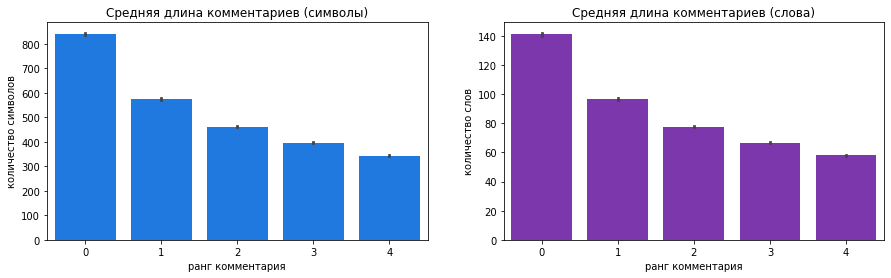

In [76]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.barplot(data = train_df, x = 'comment_score', y = 'symbols', estimator ='mean', color='#0077ff')
plt.xlabel('ранг комментария')
plt.ylabel('количество символов')
plt.title('Средняя длина комментариев (символы)')

plt.subplot(1, 2, 2)
sns.barplot(data = train_df, x = 'comment_score', y = 'words', estimator ='mean', color='#7f24bf')
plt.xlabel('ранг комментария')
plt.ylabel('количество слов')
plt.title('Средняя длина комментариев (слова)')

Text(0, 0.5, 'количество ссылок')

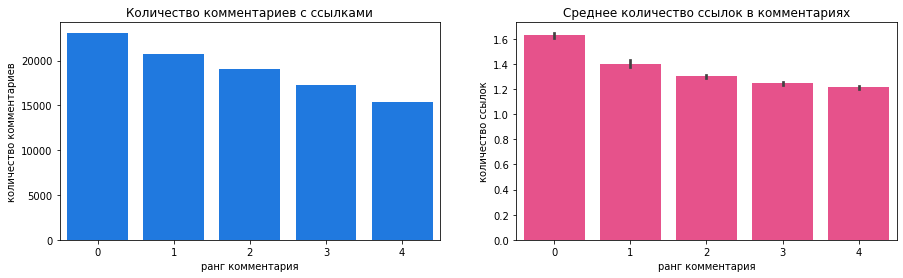

In [79]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.barplot(data = train_df[train_df['url'] == 1], x = 'comment_score', y = 'url', estimator ='sum', color='#0077ff')
plt.title('Количество комментариев с ссылками')
plt.xlabel('ранг комментария')
plt.ylabel('количество комментариев')

plt.subplot(1, 2, 2)
sns.barplot(data = train_df[train_df['url'] == 1], x = 'comment_score', y = 'count_url', estimator ='mean', color='#ff3986')
plt.title('Среднее количество ссылок в комментариях')
plt.xlabel('ранг комментария')
plt.ylabel('количество ссылок')

Text(0, 0.5, 'количество комментариев')

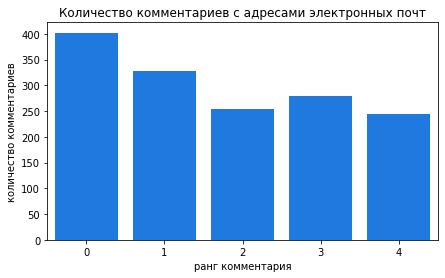

In [80]:
plt.figure(figsize=(7, 4))

sns.barplot(data = train_df[train_df['email'] == 1], x = 'comment_score', y = 'email', estimator ='sum', color='#0077ff')
plt.title('Количество комментариев с адресами электронных почт')
plt.xlabel('ранг комментария')
plt.ylabel('количество комментариев')

Text(0, 0.5, 'количество чисел')

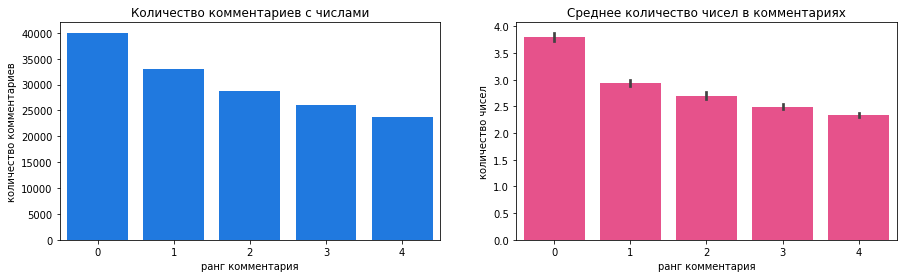

In [81]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.barplot(data = train_df[train_df['num'] == 1], x = 'comment_score', y = 'num', estimator ='sum', color='#0077ff')
plt.title('Количество комментариев с числами')
plt.xlabel('ранг комментария')
plt.ylabel('количество комментариев')

plt.subplot(1, 2, 2)
sns.barplot(data = train_df[train_df['num'] == 1], x = 'comment_score', y = 'count_num', estimator ='mean', color='#ff3986')
plt.title('Среднее количество чисел в комментариях')
plt.xlabel('ранг комментария')
plt.ylabel('количество чисел')

Text(0, 0.5, 'количество слов')

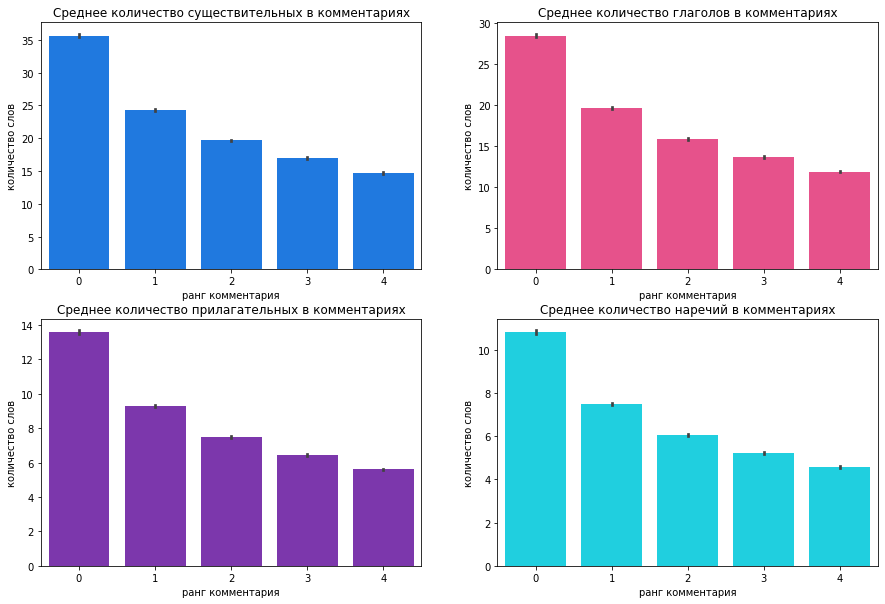

In [82]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(data = train_df, x = 'comment_score', y = 'noun', estimator ='mean', color='#0077ff')
plt.title('Среднее количество существительных в комментариях')
plt.xlabel('ранг комментария')
plt.ylabel('количество слов')

plt.subplot(2, 2, 2)
sns.barplot(data = train_df, x = 'comment_score', y = 'verb', estimator ='mean', color='#ff3986')
plt.title('Среднее количество глаголов в комментариях')
plt.xlabel('ранг комментария')
plt.ylabel('количество слов')

plt.subplot(2, 2, 3)
sns.barplot(data = train_df, x = 'comment_score', y = 'adj', estimator ='mean', color='#7f24bf')
plt.title('Среднее количество прилагательных в комментариях')
plt.xlabel('ранг комментария')
plt.ylabel('количество слов')

plt.subplot(2, 2, 4)
sns.barplot(data = train_df, x = 'comment_score', y = 'adv', estimator ='mean', color='#00eaff')
plt.title('Среднее количество наречий в комментариях')
plt.xlabel('ранг комментария')
plt.ylabel('количество слов')

Text(0, 0.5, 'количество совпадающих слов')

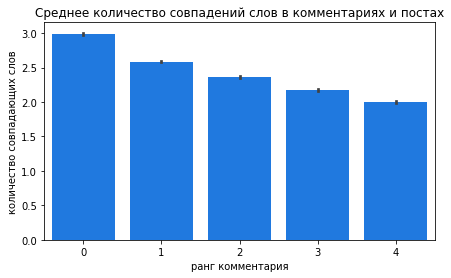

In [86]:
plt.figure(figsize=(7, 4))

sns.barplot(data = train_df, x = 'comment_score', y = 'matches', estimator ='mean', color='#0077ff')
plt.title('Среднее количество совпадений слов в комментариях и постах')
plt.xlabel('ранг комментария')
plt.ylabel('количество совпадающих слов')